#### Poisson

\begin{eqnarray}
{\bf \nabla} \left(\varepsilon ({\bf r}) {\bf \nabla} \phi ({\bf r}) \right) &=& -\rho({\bf r}) \\
\rho({\bf r}) &=& q \left(-N_A({\bf r}) - n_e({\bf r}) + N_D({\bf r}) + n_h({\bf r}) \right)
\end{eqnarray}

#### Conservation

\begin{eqnarray}
\frac{d}{dt} n_e({\bf r}) &=& {\bf \nabla} {\bf J}_e ({\bf r}) + G({\bf r}) - U({\bf r}) \\
\frac{d}{dt} n_h({\bf r}) &=& {\bf \nabla} {\bf J}_h ({\bf r}) + G({\bf r}) - U({\bf r})
\end{eqnarray}

#### Density Current

\begin{eqnarray}
{\bf J}_e &=& \mu_e n_e {\bf \nabla} \phi - D_e {\bf \nabla} n_e \\
{\bf J}_h &=& - \mu_h n_h {\bf \nabla} \phi -  D_h {\bf \nabla} n_h \\
\mu_e &=& \frac{q D_e}{k_B T} \\
\mu_h &=& \frac{q D_h}{k_B T}
\end{eqnarray}

#### Electric Current
\begin{eqnarray}
{\bf J}_e &=& q \mu_e n_e (-{\bf \nabla} \phi) + q D_e {\bf \nabla} n_e \\
{\bf J}_h &=&  q \mu_h n_h (-{\bf \nabla} \phi) -  q D_h {\bf \nabla} n_h \\
\end{eqnarray}

In [1]:
import os, sys, re, glob, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import simps
from collections import OrderedDict
#import ase
#from ase.data import kB
mpl.rcParams.update({'font.size':16})
%matplotlib inline

kB = 8.6173303e-5 # eV / K
kB_inJ = 1.38064852e-23 # J / K
e = 1.602176462e-19 # Coulomb
epsilon_Si = 12.0
epsilon_0 = 8.854187817e-12 # F / m = C / V m,  F = C/V
q_eps0 = e/epsilon_0 # C (C/Vm)^-1 = V m
# d2/dx2 phi = q rho / epsilon_0 : C m^-3 / (C/V m) = V m^-2

/Users/nagoyan/anaconda/envs/p3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
print('{:.6e} {:.6e}'.format(q_eps0, e/(kB_inJ*300)))

1.809513e-08 3.868174e+01


In [3]:

def SOR(A, b, tol, debug=False, xOld=None):
    # 線形連立方程式を SOR 法で解く
    if xOld is None:
        xOld = np.empty_like(b)
    error = 1e12

    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = A - L - D

    Mj = np.dot(np.linalg.inv(D), -(L+U))
    rho_Mj = max(abs(np.linalg.eigvals(Mj)))
    if (1-rho_Mj**2)>0:
        w = 2/(1+np.sqrt(1-rho_Mj**2))
    else:
        w = 1.6 # 1.0 : Gauss-Seidel
    if debug:
        print('D : \n',D)
        print('L : \n',L)
        print('U : \n',U)
        print('Mj : ', Mj)
        print('rho_Mj :\n', rho_Mj)
        print(1-rho_Mj**2)
    T = np.linalg.inv(D+w*L)
    Lw = np.dot(T, -w*U+(1-w)*D)
    c = np.dot(T, w*b)

    while error > tol:
        x = np.dot(Lw, xOld) + c
        error = np.linalg.norm(x-xOld)/np.linalg.norm(x)
        xOld = x
    return x

A = np.array([[7, -1, 0, 1],
              [-1, 9, -2, 2],
              [0, -2, 8, -3],
              [1, 2, -3, 10]])
b = np.array([-5, 15, -10, 20])

x = SOR(A, b, 1e-9, True)
print(x)

#--> same result
fac = 5
x2 = SOR(A,b*fac,1e-9, debug=False)
print(x2/fac)

D : 
 [[ 7  0  0  0]
 [ 0  9  0  0]
 [ 0  0  8  0]
 [ 0  0  0 10]]
L : 
 [[ 0  0  0  0]
 [-1  0  0  0]
 [ 0 -2  0  0]
 [ 1  2 -3  0]]
U : 
 [[ 0 -1  0  1]
 [ 0  0 -2  2]
 [ 0  0  0 -3]
 [ 0  0  0  0]]
Mj :  [[ 0.          0.14285714  0.         -0.14285714]
 [ 0.11111111  0.          0.22222222 -0.22222222]
 [ 0.          0.25        0.          0.375     ]
 [-0.1        -0.2         0.3         0.        ]]
rho_Mj :
 0.5254032883446224
0.7239513845966576
[-0.80693816  1.11613876 -0.3092006   1.76470588]
[-0.80693816  1.11613876 -0.3092006   1.76470588]


In [4]:
cm=1e-2
nm=1e-9
print(cm**3, nm**3)

1.0000000000000002e-06 1.0000000000000002e-27


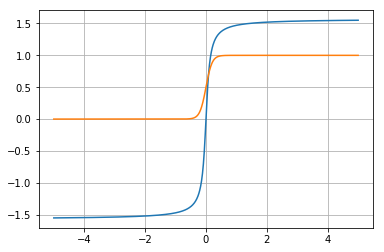

In [5]:
#--> test arctan and sigmoid for fixed charge distributions.
mesh = np.linspace(-5, 5, 1000)
fac=10
plt.plot(mesh, np.arctan(fac*(mesh-np.average(mesh))))
plt.plot(mesh, 1/(1+np.exp(fac*(-mesh-np.average(-mesh)))))
plt.grid()

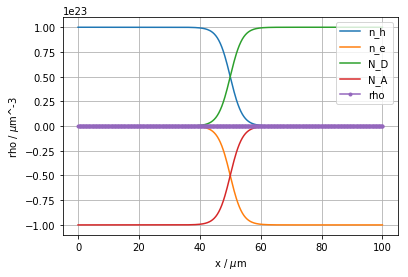

In [32]:
#--> set inputs
Lx = 100.0e-6  # sample width 100 micron
xlim = [0.0, Lx] # length [nm]
nmesh=401
center = int((nmesh-1)/2)
mesh = np.linspace(*xlim, nmesh)

N_A0 = 1e17
N_A0 *= 1e6 # [cm-3 -> m-3]
N_D0 = 1e17
N_D0 *= 1e6

T = 300.0  # K

epsilon = epsilon_Si * epsilon_0
q = e
qkt = q/(kB_inJ*T)

# D=mu kB T / q
mu_e = 0.15  #  m^2 / V s 
mu_h = 0.05  #  m^2 / V s
D_e = mu_e / qkt
D_h = mu_h / qkt

n_e = np.zeros_like(mesh)
n_h = np.zeros_like(mesh)
phi = np.zeros_like(mesh)
N_A = np.zeros_like(mesh)
N_D = np.zeros_like(mesh)

fac=5e5
N_A = N_A0 * 1/(1+np.exp(fac*(mesh-np.average(mesh)) ))
N_D = N_D0 * 1/(1+np.exp(fac*(-mesh-np.average(-mesh)) ))
#n_h[:] = simps(N_A, mesh)/Lx
#n_e[:] = simps(N_D, mesh)/Lx
n_h[:] = N_A.copy()
n_e[:] = N_D.copy()

G = np.zeros_like(mesh)
U = np.zeros_like(mesh)

def get_rho(n_h, n_e, N_D, N_A):
     return (n_h - n_e + N_D - N_A)
rho = get_rho(n_h, n_e, N_D, N_A)

n_h0 = n_h.copy()
n_e0 = n_e.copy()
phi0 = phi.copy()
rho0 = rho.copy()

_x = mesh * 1e6
plt.plot(_x, n_h, label='n_h')
plt.plot(_x, -n_e, label='n_e')
plt.plot(_x, N_D, label='N_D')
plt.plot(_x, -N_A, label='N_A')
plt.plot(_x, rho, '.-', label='rho')
ax = plt.gca()
ax.set_xlabel('x / $\mu$m')
ax.set_ylabel('rho / $\mu$m^-3')
ax.legend()
plt.grid()

1.0000000000000002 [1.00656216 0.9878544  0.99223628 1.01357719 1.007854   1.04531914
 1.06880948 1.00484196 0.94104449 0.95285665]


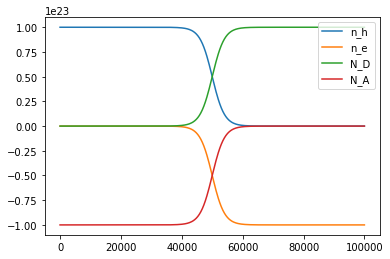

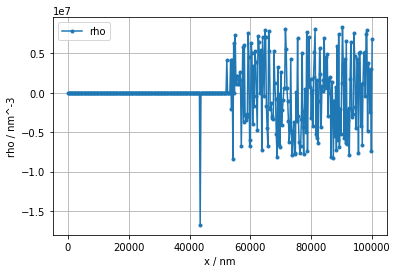

In [33]:
def tmp(a, n=10):
    tmp = a.copy()
    for i in range(n):
        tmp[i] = np.average(a[0:i+n])
        tmp[-(i+1)] = np.average(a[-i-1-n:])
    for i in range(n, len(a)-n):
        tmp[i] = np.average(a[i-n:i+n])
    return tmp

def get_random(nmesh, fac=0.1, nave=0.05):
    _random = tmp(np.random.random(nmesh), n=int(nmesh*nave))
    _random = tmp(_random, n=int(nmesh*nave))
    _random = 1.0 + (_random - np.average(_random))*fac
    return _random

_random = get_random(100, fac=1.0, nave=0.1)
print(np.average(_random), _random[::10])

#_random = (_random - np.average(_random))
#n_e0 = n_e0 + _random
#n_h0 = n_h0 - _random[::-1]
#n_e0 = n_e + _random 

#_n_e0 = n_e0 * get_random(nmesh, fac=0.5, nave=0.2)
#_n_h0 = n_h0 * get_random(nmesh, fac=0.5, nave=0.2)
_n_e0 = n_e0.copy()
_n_h0 = n_h0.copy()

_x = mesh * 1e9
plt.plot(_x, _n_h0, label='n_h')
plt.plot(_x, -_n_e0, label='n_e')
plt.plot(_x, N_D, label='N_D')
plt.plot(_x, -N_A, label='N_A')
plt.legend()
plt.show()

plt.plot(_x, get_rho(_n_h0, _n_e0, N_D, N_A), '.-', label='rho')
ax = plt.gca()
ax.set_xlabel('x / nm')
ax.set_ylabel('rho / nm^-3')
ax.legend()
plt.grid()

In [34]:
np.max(rho)

8305669.59375

In [35]:
print('epsilon_0/q = {:e} [V^-1 m^-1]'.format(epsilon_0/q))

epsilon_0/q = 5.526350e+07 [V^-1 m^-1]


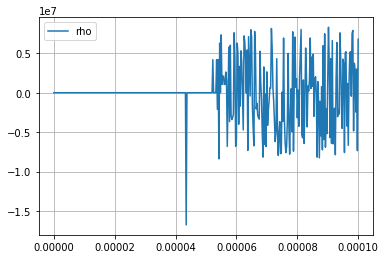

[[-1.   1.   0.  ...  0.   0.   0. ]
 [ 0.5 -1.   0.5 ...  0.   0.   0. ]
 [ 0.   0.5 -1.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ... -1.   0.5  0. ]
 [ 0.   0.   0.  ...  0.5 -1.   0.5]
 [ 0.   0.   0.  ...  0.   1.  -1. ]]
D : 
 [[-1.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]
L : 
 [[0.  0.  0.  ... 0.  0.  0. ]
 [0.5 0.  0.  ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.5 0.  0. ]
 [0.  0.  0.  ... 0.  1.  0. ]]
U : 
 [[0.  1.  0.  ... 0.  0.  0. ]
 [0.  0.  0.5 ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.  0.  0.5]
 [0.  0.  0.  ... 0.  0.  0. ]]
Mj :  [[0.  1.  0.  ... 0.  0.  0. ]
 [0.5 0.  0.5 ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.5 0.  0.5]
 [0.  0.  0.

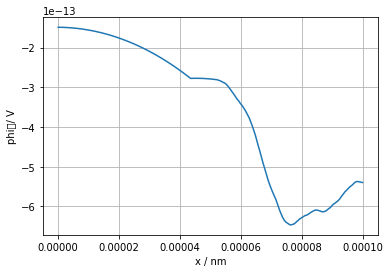

In [36]:

def SOR(A, b, tol, debug=False, xOld=None):
    # 線形連立方程式を SOR 法で解く

    if xOld is None:
#        xOld = np.empty_like(b)
        xOld=np.random.randn(len(b))

    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = A - L - D

    Mj = np.dot(np.linalg.inv(D), -(L+U))
    rho_Mj = max(abs(np.linalg.eigvals(Mj)))
    if (1-rho_Mj**2)>0:
        w = 2/(1+np.sqrt(1-rho_Mj**2))
    else:
        w = 1.6 # w=1.0 : Gauss-Seidel
        
    if debug:
        print('D : \n',D)
        print('L : \n',L)
        print('U : \n',U)
        print('Mj : ', Mj)
        print('rho_Mj :\n', rho_Mj)
        print(1-rho_Mj**2)
    
    T = np.linalg.inv(D+w*L)
    Lw = np.dot(T, -w*U+(1-w)*D)
    c = np.dot(T, w*b)

    error = 1e120
    while error > tol:
        x = np.dot(Lw, xOld) + c
        error = np.linalg.norm(x-xOld)/np.linalg.norm(x)
        xOld = x
 
    return x

def get_phi(mesh, rho, epsilon, q, tol=1e-4, debug=False, scale_fac=None):
    dx = mesh[1]-mesh[0]
    n = len(mesh)

    A = np.eye(n)
    A *= -1

    #--> dphi/dx = 0 at the boundary.
    A[0, 1] = A[-1, -2] = 1


    for i in range(1, n-1):
        A[i, i+1] = A[i, i-1] = 1/2
        
    if debug:
        print(A)

    #--> set scale factor for tiny rho values below the numerical accuracy.
    if isinstance(scale_fac, (float, int)):
        _scale_fac = scale_fac
    elif scale_fac is True:
        _scale_fac = np.max(np.abs(rho))
    else:
        _scale_fac = 1.0
        
    _fac = -_scale_fac * 2/dx**2 * epsilon / q

    _rho = _scale_fac * rho #--> -dx**2/2*(q/epsilon)*rho * _fac
#    _rho = dx**2/2 *( -q / epsilon) * rho
#    _rho = _scale_fac * dx**2/2 * (-q/epsilon) * rho
    _rho[0] = _rho[-1] = 0.0
    
#    _rho[0] = _rho[-1] = 1e-16
#    xOld = np.empty_like(_rho)
    xOld = np.random.randn(len(_rho))
    xOld[0] = 0.0
    
    _phi = SOR(A, _rho, tol, debug=debug, xOld=xOld)
    if debug:
        print(1/_fac)
    phi = _phi / _fac

    return phi

#print(mesh)
#print(rho0)
#print(epsilon)

_rho = get_rho(_n_h0, _n_e0, N_D, N_A)
plt.plot(mesh, _rho, label='rho')
plt.grid()
plt.legend()
plt.show()

phi = get_phi(mesh, _rho, epsilon, q, debug=True, scale_fac=1e3)
print(phi)
plt.plot(mesh, phi)
ax=plt.gca()
ax.set_xlabel('x / nm')
ax.set_ylabel('phi　/ V')
plt.grid()

In [37]:
phi*q

array([-2.38480175e-32, -2.38512298e-32, -2.38557274e-32, -2.38615102e-32,
       -2.38685785e-32, -2.38769325e-32, -2.38865722e-32, -2.38974980e-32,
       -2.39097101e-32, -2.39232087e-32, -2.39379941e-32, -2.39540665e-32,
       -2.39714262e-32, -2.39900737e-32, -2.40100091e-32, -2.40312330e-32,
       -2.40537455e-32, -2.40775472e-32, -2.41026384e-32, -2.41290196e-32,
       -2.41566911e-32, -2.41856536e-32, -2.42159074e-32, -2.42474530e-32,
       -2.42802910e-32, -2.43144218e-32, -2.43498461e-32, -2.43865644e-32,
       -2.44245773e-32, -2.44638854e-32, -2.45044893e-32, -2.45463896e-32,
       -2.45895870e-32, -2.46340822e-32, -2.46798759e-32, -2.47269687e-32,
       -2.47753615e-32, -2.48250548e-32, -2.48760496e-32, -2.49283465e-32,
       -2.49819464e-32, -2.50368500e-32, -2.50930583e-32, -2.51505720e-32,
       -2.52093920e-32, -2.52695191e-32, -2.53309543e-32, -2.53936985e-32,
       -2.54577526e-32, -2.55231175e-32, -2.55897943e-32, -2.56577838e-32,
       -2.57270871e-32, -

0.9999994265189295


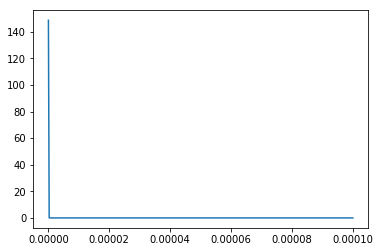

2.5e-07 55263499.53954073
0.0 4.5499999999999995e-05 6.374999999999999e-05 0.0001 401 1.2499999999999999e-06
charges : 
-1.0 1.0


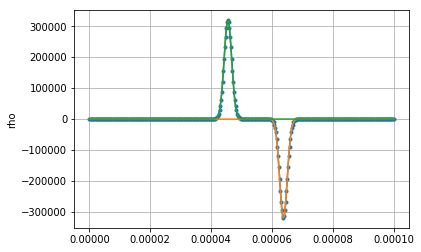

1.8249999999999996e-05
get phi in 0 trials
[8.60584912e-14 8.60684569e-14 8.60824059e-14 8.61003366e-14
 8.61222469e-14] [-1.15977734e-13 -1.15971864e-13 -1.15969909e-13 -1.15971866e-13
 -1.15977736e-13]
get phi in 0 trials
[8.60584912e-14 8.60684569e-14 8.60824060e-14 8.61003366e-14
 8.61222469e-14] [-1.15977734e-13 -1.15971864e-13 -1.15969909e-13 -1.15971866e-13
 -1.15977736e-13]
get phi in 0 trials
[8.60584912e-14 8.60684569e-14 8.60824060e-14 8.61003366e-14
 8.61222469e-14] [-1.15977734e-13 -1.15971864e-13 -1.15969909e-13 -1.15971866e-13
 -1.15977736e-13]
get phi in 0 trials
[8.60584912e-14 8.60684569e-14 8.60824060e-14 8.61003366e-14
 8.61222469e-14] [-1.15977734e-13 -1.15971864e-13 -1.15969909e-13 -1.15971866e-13
 -1.15977736e-13]
get phi in 0 trials
[8.60584912e-14 8.60684569e-14 8.60824060e-14 8.61003366e-14
 8.61222469e-14] [-1.15977734e-13 -1.15971864e-13 -1.15969909e-13 -1.15971866e-13
 -1.15977736e-13]


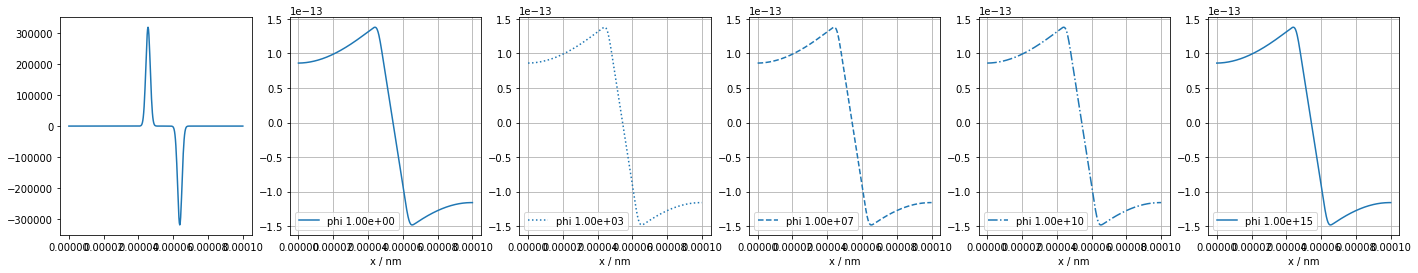

In [38]:
def gauss(x, x0, s):
    _g = np.zeros_like(x)
    for i, _x in enumerate(x):
        _g[i] = 1/np.sqrt(2*np.pi*s**2)*np.exp(-((_x-x0)/s)**2/2)
    return _g

from scipy.integrate import simps
_mesh = np.linspace(0, 1, 101)
print(simps(gauss(_mesh, 0.5, 0.1), _mesh))

plt.plot(mesh, gauss(mesh, 5e-8, 1e-8))
plt.show()

#mesh=x
dx = mesh[1]-mesh[0]
_s = dx*5

print(dx, epsilon_0/q)

_xp = mesh[int(len(mesh)*5/11)]
_rhop = gauss(mesh, _xp, _s)

_xm = mesh[int(len(mesh)*7/11)]
_rhom = -gauss(mesh, _xm, _s)

print(mesh[0], _xp, _xm, mesh[-1], len(mesh), _s)
print('charges : ', end=None)
print(simps(_rhom, mesh), simps(_rhop, mesh))

plt.plot(mesh, _rhom + _rhop, '.-')
plt.plot(mesh, _rhom)
plt.plot(mesh, _rhop)
plt.grid()
plt.gca().set_ylabel('rho')
#_rho = get_rho(n_h0, n_e0, N_D0, N_A0)

plt.show()

#--> get_phi frequently failed.
#--> test phi using scaling factor.

facs = [1.0, 1e3, 1e7, 1e10, 1e15] 
ls = ['-', ':', '--', '-.']
ls = ls + ls
huge = 1e100
ncols=len(facs)+1
fig, axes = plt.subplots(ncols=ncols, figsize=(4*ncols, 4))

_rho_tmp = _rhom + _rhop
print(mesh[int(len(mesh)*7/11)] -mesh[int(len(mesh)*5/11)])
#_rho_tmp = get_rho(_n_h0, _n_e0, N_D, N_A)
#_rho_tmp = np.zeros_like(_n_h0)
#_rho_tmp[50:55] = 1.0
#_rho_tmp[-55:-50] = -1.0

axes[0].plot(mesh, _rho_tmp, label='rho')

for i, (_ax, _fac) in enumerate(zip(axes[1:], facs)):
    _phi = get_phi(mesh, _rho_tmp, epsilon_0, q, debug=False, scale_fac=_fac)
    count, count_max = 0, 1000

    for count in range(0, count_max):
        if np.max(np.abs(_phi)) > huge:
            _phi = get_phi(mesh, _rho_tmp, epsilon_0, q, debug=False, scale_fac=_fac)
        else:
            print('get phi in {} trials'.format(count))
            break
    else:
        print('can not get phi in {} trials.'.format(count))
        _phi = get_phi(mesh, _rho_tmp, epsilon_0, q, debug=False, scale_fac=True)
        
    print(_phi[:5], _phi[-5:])
    _ax.plot(mesh, _phi, label='phi {:.2e}'.format(_fac), linestyle=ls[i])
    _ax.set_xlabel('x / nm')
    _ax.legend()
    _ax.grid()

plt.show()

In [39]:
print(np.diff(_phi).size,np.gradient(_phi,dx).size)


400 401


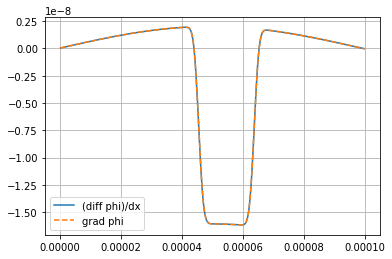

In [40]:
dx = (mesh[1]-mesh[0])
plt.plot(mesh[0:-1]+dx/2, np.diff(_phi, 1)/dx, label='(diff phi)/dx')
plt.plot(mesh, np.gradient(_phi, dx), '--', label='grad phi')

plt.legend()
plt.grid()


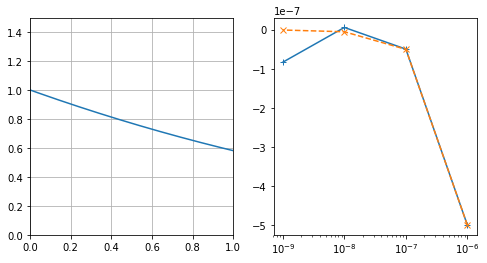

In [41]:
#--> lim x-> 0, x/(e^x -1)  should be 1 but it goes inf for small x by error.
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
ax0, ax1 = axes

_x = np.arange(-2, 2, 0.01)
tmp = [_/(np.exp(_)-1) for _ in _x]
ax0.plot(_x,tmp)
ax0.set_xlim(0,1)
ax0.set_ylim(0,1.5)
ax0.grid()

x2 = [10**(-_) for _ in range(6,10)]
tmp2 = np.array([_/(np.exp(_) -1 ) for _ in x2])
tmp3 = np.array([1.0-0.5*_ for _ in x2])
ax1.plot(x2, tmp2-1, '+-')
ax1.plot(x2, tmp3-1, 'x--')
ax1.set_xscale('log')

### Sharfetter-Gummel

\begin{eqnarray}
  \frac{d}{dx} J(x_i) &=& \frac{1}{dx} \left( J_{i+\frac{1}{2}} - J_{i-\frac{1}{2}} \right) \\
  &=& \frac{1}{dx}[ D \left( -B(-t_i) n_{i+1} + B(t_i) n_i  \right) + D \left(B(-t_{i-1}) n_i - B(t_{i-1}) n_{i-1} \right) ]\\ 
  &=& \frac{1}{dx} D \left( a_{i+1} n_{i+1} + a_i n_i + a_{i-1} n_{i-1} \right) 
\end{eqnarray}

where

\begin{eqnarray}
a_{i+1} &=& -B(-t_i)  \\
      a_i &=& B(t_i) + B(-t_{i-1})  \\
a_{i-1}  &=& -B(t_{i-1})  \\
B(t) &=& \frac{t}{e^t -1} \\
t_i &=& \beta \Delta \phi_i  \\
     &=& \left(\frac{q}{k_B T}\right)\left(\phi_{i+1} - \phi_i\right) \\
\end{eqnarray}

間違っている？
\begin{eqnarray}
a_{i+1} &=& -B(t_i)  \\
      a_i &=& B(-t_i) + B(t_{i-1})  \\
a_{i-1}  &=& -B(-t_{i-1})  \\
B(t) &=& \frac{t}{e^t -1} \\
t_i &=& \beta \Delta \phi_i  \\
     &=& \left(\frac{q}{k_B T}\right)\left(\phi_{i+1} - \phi_i\right) \\
\end{eqnarray}
確認する．


両端の境界条件どうする？　

N点メッシュx=\{$x_0$ ... $x_{N-1}$}に対して，とりあえず下記を使う：

両端のCurrentは0：

\begin{eqnarray}
J_{0-1/2} &=& 0 \\
J_{N-1+1/2} &=& 0
\end{eqnarray}

\begin{eqnarray}
  \frac{d}{dx} J(x_0) &=& \frac{1}{dx} （J_{\frac{1}{2}} - J_{-\frac{1}{2}}) \\
  &=& \frac{1}{dx} D \left( -B(t_0) n_{1} + B(-t_0) n_0 \right) \\ 
  &=& \frac{1}{dx} D \left( a_{1} n_{1} + a_0 n_0 \right)  \\
  where \\
  a_{1} &=& -B(t_0) \\
  a_{0} &=& B(-t_0) \\
\end{eqnarray}


\begin{eqnarray}
  \frac{d}{dx} J(x_{N-1}) &=& \frac{1}{dx} \left( J_{N-1+\frac{1}{2}} - J_{N-1-\frac{1}{2}} \right) \\
  &=& \frac{1}{dx} D \left( B(t_{N-2}) n_{N-1} - B(-t_{N-2}) n_{N-2} \right) \\ 
  &=& \frac{1}{dx} D \left( a_{N-1} n_{N-1} + a_{N-2} n_{N-2} \right) \\
  where \\
  a_{N-1} &=& B(t_{N-2}) \\
  a_{N-2} &=& -B(-t_{N-2})
\end{eqnarray}


In [42]:
mask=[True, False]
np.arange(2)[np.array(mask)==False]

array([1])

In [43]:

def get_dndt(mesh, phi, n, D, G, U, qkt, debug=False):
    nmesh = len(mesh)

    def B(qkt, phi, tol=1e-8):
        t = qkt * np.diff(phi)
        mask = np.array(t) > tol
        t[mask==False] = 1.0-0.5*t[mask==False]
        t[mask] = t[mask]/(np.exp(t[mask])-1)
        return t
    
    bp = B(qkt, phi)
    bm = B(qkt, -phi)
    a = np.zeros((nmesh, nmesh))
    a[0, 1] = -bp[0]
    a[0, 0] = bm[0]
    a[nmesh-1, nmesh-1] = bp[nmesh-2]
    a[nmesh-1, nmesh-2] = -bm[nmesh-2]

    if debug:
        print(bp.shape, bm.shape, a.shape)
        print(bp[0:5],bp[-5:], bm[0:5],bm[-5:])

    for i in range(1, nmesh-1):
        a[i, i+1] = -bp[i]
        a[i, i] = bm[i] + bp[i-1]
        a[i, i-1] = -bm[i-1]

    dx = mesh[1] - mesh[0]
    dx2_inv = 1/dx**2
    djdx = dx2_inv * D * (a @ n)
    dnhdt = djdx + G - U
    if debug:
        return dnhdt, a, n
    else:
        return dnhdt 


(400,) (400,) (401, 401)
[1. 1. 1. 1. 1.] [1. 1. 1. 1. 1.] [1. 1. 1. 1. 1.] [1. 1. 1. 1. 1.]
(400,) (400,) (401, 401)
[1. 1. 1. 1. 1.] [1. 1. 1. 1. 1.] [1. 1. 1. 1. 1.] [1. 1. 1. 1. 1.]
rho [0. 0. 0. 0. 0.] [ 2816870.87597656 -2459509.37792969  2997857.16088867 -7349861.52441406
  6776786.89038086] 16777216.0
phi [ 0.00000000e+00 -2.00499738e-17 -4.81213608e-17 -8.42150145e-17
 -1.28331902e-16] [-3.89230791e-13 -3.89855293e-13 -3.90259633e-13 -3.90958142e-13
 -3.90975594e-13] 4.978825970186873e-13
dnh [3.82614387e+21 5.08672070e+20 5.78067987e+20 6.53015577e+20
 7.42536310e+20] [-7.40891581e+20 -6.53834525e+20 -5.77006943e+20 -5.09206840e+20
 -3.82435416e+21] 3.100622157533777e+30
dne [-1.14730625e+22 -1.52762052e+21 -1.73102083e+21 -1.96150358e+21
 -2.22267474e+21] [2.16098885e+21 2.01109367e+21 1.66133825e+21 1.69048453e+21
 1.14784316e+22] 9.301866472601851e+30


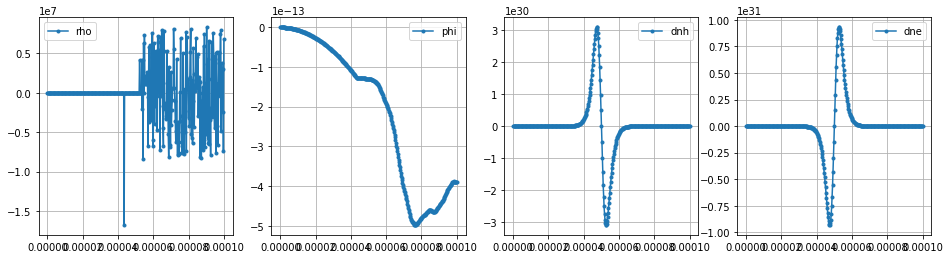

In [44]:
dx = mesh[1]-mesh[0]
dx_inv = 1/dx**2

_fac=1e10
_rho_tmp = get_rho(_n_h0, _n_e0, N_D, N_A)
_phi = get_phi(mesh, _rho_tmp, epsilon, q, debug=False, scale_fac=_fac)
_phi = _phi - _phi[0] #--> set the leftmost value to zero. 

dnh, _ah, _nh = get_dndt(mesh, -_phi, _n_h0, D_h, G, U, qkt, True)
dne, _ae, _ne = get_dndt(mesh, _phi, _n_e0, D_e, G, U, qkt, True)

ncols=4
fig, axes = plt.subplots(ncols=ncols, figsize=(ncols*4, 4))
label_data = OrderedDict([('rho',_rho_tmp), ('phi',_phi), ('dnh',dnh), ('dne', dne)])
for _ax, (_l, _d) in zip(axes, label_data.items()):
    print(_l, _d[:5], _d[-5:], np.max(np.abs(_d)))
    _ax.plot(mesh, _d, '.-', label=_l)
    _ax.grid()
    _ax.legend()



iteration 0 dnmax is too large :9.3019e+30 > 1.0000e+24
new dnmax 1.9948047876923948e+36
iteration 0 finished.
iteration 1 dnmax is too large :1.2768e+62 > 9.9715e+36
new dnmax 6.896718464825452e+29
iteration 2 dnmax is too large :3.1936e+61 > 4.9871e+36
new dnmax 6.89718793324322e+29
iteration 3 dnmax is too large :7.9831e+60 > 2.4934e+36
new dnmax 6.896748755930497e+29
iteration 4 dnmax is too large :1.9957e+60 > 1.2467e+36
new dnmax 6.896827596420356e+29
iteration 5 dnmax is too large :4.9894e+59 > 6.2335e+35
new dnmax 6.896963942283661e+29
iteration 6 dnmax is too large :1.2474e+59 > 3.1168e+35
new dnmax 6.89726066313628e+29
iteration 7 dnmax is too large :3.1183e+58 > 1.5584e+35
new dnmax 6.897841773307758e+29
iteration 8 dnmax is too large :7.7957e+57 > 7.7920e+34
new dnmax 6.898997613409649e+29
iteration 9 dnmax is too large :1.9489e+57 > 3.8961e+34
new dnmax 6.90129549958197e+29
iteration 10 dnmax is too large :4.8719e+56 > 1.9482e+34
new dnmax 6.905833556075743e+29
iteration 1

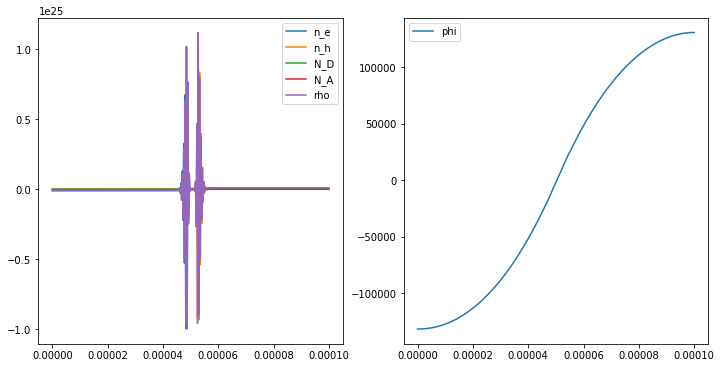

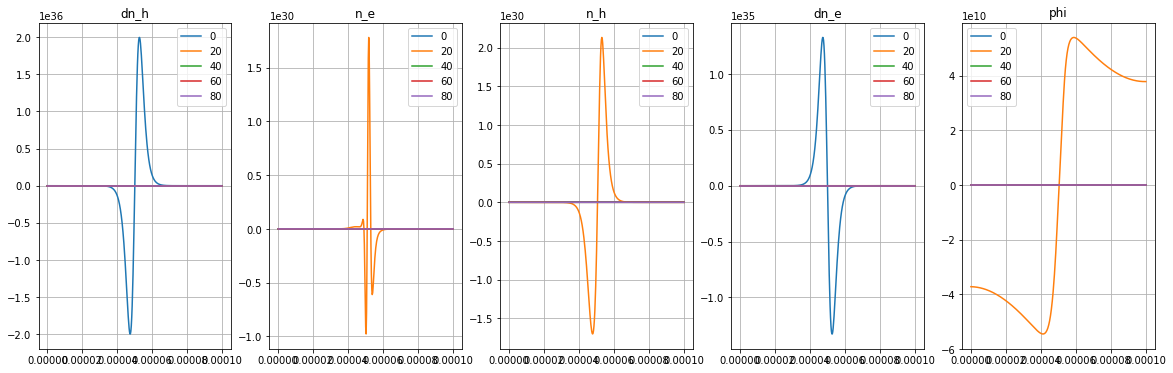

In [51]:
n_h = _n_h0
n_e = _n_e0
phi = phi0

dx = mesh[1]-mesh[0]
dx_inv = 1/dx

nmesh = len(mesh)
nit = 100

_rho = np.zeros([nit, nmesh])
_phi = np.zeros([nit, nmesh])
_n_e = np.zeros([nit, nmesh])
_n_h = np.zeros([nit, nmesh])
_dne = np.zeros([nit, nmesh])
_dnh = np.zeros([nit, nmesh])

dne = [np.inf]
dnh = [np.inf]

ne_tot = simps(N_D, mesh)/Lx
nh_tot = simps(N_A, mesh)/Lx

itmp = int(nit/10)
huge=1e100
scale_facs=[1e3, 1e6, 1e9, 1e12, 1e15, 1e18]
count_max = len(scale_facs) + 1
for i in range(nit):
    dne0 = np.sum(dne)
    dnh0 = np.sum(dnh)
    
    rho = get_rho(n_h, n_e, N_D, N_A)

    phi = get_phi(mesh, rho, epsilon, q, debug=False, scale_fac=True)

    _phi_max =  np.max(np.abs(phi))
    _count = 0
    while _count < count_max and (_phi_max > huge  or np.isnan(_phi_max)):
        if _phi_max > huge:
            print('iteration {}, trial {},  phi is too large : {} > {}'.format(i, _count, _phi_max, huge))
        else:
            print('iteration {}, trial {}, phi is np.nan : {}'.format(i, _count, _phi_max))

        if _count < len(scale_facs):
                _scale_fac = scale_facs[_count]
        else:
                _scale_fac = True
        phi = get_phi(mesh, rho, epsilon, q, debug=False, scale_fac=_scale_fac)
        _phi_max =  np.max(np.abs(phi))
        _count += 1

    if _count == count_max:
        print('get_phi diverged. use old phi')
        phi = _phi[-1]
        
    dnh = get_dndt(mesh, phi, n_h, D_h, G, U, qkt)
    dne = get_dndt(mesh, -phi, n_e, D_e, G, U, qkt)
    

    _dnmax = np.max(np.abs(np.concatenate([dne, dnh])))
    nmax = np.max(np.abs(np.concatenate([n_e, n_h])))*10


    if _dnmax > nmax:
        print('iteration {} dnmax is too large :{:.4e} > {:.4e}'.format(i, _dnmax, nmax), end=None)
        dnh = dnh / simps(dnh, mesh)*simps(n_h, mesh)
        dne = dne / simps(dne, mesh)*simps(n_e, mesh)
        _dnmax = np.max(np.abs(np.concatenate([dne, dnh])))
        nmax = np.max(np.abs(np.concatenate([n_e, n_h])))                    
        print('new dnmax', _dnmax)
        
    _rho[i] = rho
    _phi[i] = phi
    _n_e[i] = n_e
    _n_h[i] = n_h
    _dne[i] = dne
    _dnh[i] = dnh
       
    n_e = n_e + dne 
    n_h = n_h + dnh
    n_e = n_e / (simps(n_e, mesh)/Lx) * ne_tot
    n_h = n_h / (simps(n_h, mesh)/Lx) * nh_tot

    if i % itmp==0:
        print('iteration {:d} finished.'.format(i))
        
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
ax0, ax1 = axes
ax0.plot(mesh, -n_e, label='n_e')
ax0.plot(mesh, n_h, label='n_h')
ax0.plot(mesh, N_D, label='N_D')
ax0.plot(mesh, -N_A, label='N_A')
ax0.plot(mesh, rho, label='rho')
ax0.legend()
ax1.plot(mesh, phi, label='phi')
ax1.legend()

dd = int(nit / 5)
ncols=5
fig, axes = plt.subplots(ncols=ncols, figsize=(4*ncols,6))
for _a, (_l,_d) in zip(axes, {'phi':_phi, 'n_e':_n_e, 'n_h':_n_h, 'dn_e':_dne, 'dn_h':_dnh}.items()):
    for i in range(0, len(_d), dd):
        _a.plot(mesh, _d[i, :].T, label=i)
        _a.set_title(_l)
        _a.legend()
        _a.grid()

In [46]:
_phi[0]

array([-1.48847634e-13, -1.48867684e-13, -1.48895755e-13, -1.48931849e-13,
       -1.48975965e-13, -1.49028107e-13, -1.49088273e-13, -1.49156467e-13,
       -1.49232689e-13, -1.49316940e-13, -1.49409223e-13, -1.49509539e-13,
       -1.49617890e-13, -1.49734279e-13, -1.49858706e-13, -1.49991175e-13,
       -1.50131687e-13, -1.50280245e-13, -1.50436852e-13, -1.50601511e-13,
       -1.50774223e-13, -1.50954993e-13, -1.51143822e-13, -1.51340714e-13,
       -1.51545673e-13, -1.51758701e-13, -1.51979802e-13, -1.52208979e-13,
       -1.52446237e-13, -1.52691579e-13, -1.52945008e-13, -1.53206530e-13,
       -1.53476147e-13, -1.53753864e-13, -1.54039686e-13, -1.54333616e-13,
       -1.54635660e-13, -1.54945822e-13, -1.55264106e-13, -1.55590518e-13,
       -1.55925062e-13, -1.56267744e-13, -1.56618568e-13, -1.56977540e-13,
       -1.57344666e-13, -1.57719950e-13, -1.58103398e-13, -1.58495017e-13,
       -1.58894811e-13, -1.59302787e-13, -1.59718950e-13, -1.60143308e-13,
       -1.60575865e-13, -

In [47]:
x=_phi[-1,-1]

In [48]:
x

130944.07254012261

In [49]:
bool(x)

True

In [31]:
np.isnan(x)

False